# Find rank of the covaraince matrix 

In [1]:
from __future__ import division
import sys
import numpy as np
import h5py
import scipy.optimize as opt


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

import matplotlib.ticker as ticker
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['legend.fontsize'] = 15
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['savefig.dpi'] = 200
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}',r'\mathchardef\mhyphen="2D']
matplotlib.rcParams['legend.fontsize'] = 12

import utils
uts = utils.MiscellaneousUtils()

## Collect the data from PE samples run

In [4]:
all_info = {}
for jj in range(10):
    f = h5py.File("/home/soumen.roy/HHM/o3inspiralhom/inspiral_hom_contribution/ScienceSegments/FinalCode/GW190814/SEOBNRv4HM/PosSamples/data/gw190814_L1_C01_60Hz_4096_0p6fISCO_0p45_%s.h5"%str(jj), 'r')

    Salpha22 = f['analysis']['Salpha22'][:]
    Salpha33 = f['analysis']['Salpha33'][:]
    Salpha44 = f['analysis']['Salpha44'][:]
    Yalpha = f['analysis']['Yalpha']
    mualpha = f['analysis']['mualpha']

    keys = f['noisebg'].keys()
    Nalpha_dataFulll = f['noisebg']['nalphas'][:][:,1:,]

    Nalpha_dataFull = Nalpha_dataFulll.copy()
    times = np.delete(f['noisebg']['nalphas'][:][:,0], [], axis=0) 

    midIdx = np.where(times > f['inputparams']['l1_end_time'][()] )[0][0]
    deltaIdx = 1200
    Nalpha_data = Nalpha_dataFull.copy()[midIdx-deltaIdx:midIdx+deltaIdx]

    # Mean at each \alpha
    mualpha = np.mean(Nalpha_dataFull, axis=0)
    xy = np.vstack([Nalpha_data[:,j] - mualpha[j] for j in range(len(mualpha))])

    # Covariance matrix
    npcov = np.cov(xy)
    
    
    info = []
    
    u0, s0, v0 = np.linalg.svd(npcov)
    for ii in range(40, 540):
        
        # Compute the inverse using pseudo-inverse method
        myinv = np.linalg.pinv( npcov, rcond=s0[ii]/max(s0) )
        
        # reconstruct the reduced covaraince matrix
        mycov = np.dot( u0[:, :ii], np.dot(np.diag(s0[:ii]), v0[:ii, :] ) )
        
        # multiply between reduced covaraince and its invers
        ccinv = np.dot(mycov, myinv)
        cinvc = np.dot(myinv, mycov  )
        
        # define reduced identity matrix
        Imat = np.zeros((540, 540))
        Imat[:ii, :ii] = np.eye(ii)
        
        # Calculate the difference of the norms
        info.append( [ii, np.linalg.norm( ccinv, 'fro') - np.linalg.norm(Imat, 'fro' ), \
                          np.linalg.norm( ccinv, 'fro') - np.linalg.norm(Imat, 'fro' ), \
                          np.trace(cinvc)**0.5 - ii**0.5 ] )
                      
        

    info = np.array(info)
    
    
    all_info[jj] = info

In [6]:
# Collect the data of difference of the norms

data = []
for jj in range(10):
    data.append( all_info[jj][:,1] )
data = np.array(data)

## Plot the envelop

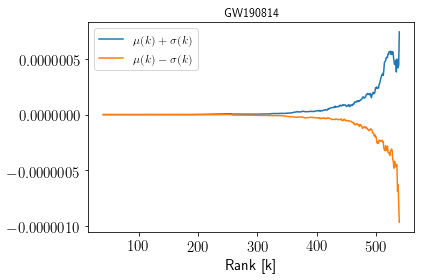

In [8]:
fig, ax = plt.subplots( figsize=(6, 4) )
ax.plot(info[:,0], np.mean(data, axis=0) + np.std(data, axis=0), label=r'$\mu(k) + \sigma(k)$' )
ax.plot(info[:,0], np.mean(data, axis=0) - np.std(data, axis=0), label=r'$\mu(k)-\sigma(k)$' )
ax.set_xlabel( 'Rank [k]' )
ax.set_title('GW190814')
ax.legend()
fig.tight_layout()
#fig.savefig('envelop_gw190814.png')

## Find $k_{max}$

In [9]:
index = np.where(2 * np.std(data, axis=0) > 2.4e-7)[0][0]

print info[:,0][index]

476.0


## Print the PE samples paramaters values

In [14]:
## print the instrinsic parametrs
## mass1 mass2 spin1z spin2z
for jj in range(10):
    f = h5py.File("/home/soumen.roy/HHM/o3inspiralhom/inspiral_hom_contribution/ScienceSegments/FinalCode/GW190814/SEOBNRv4HM/PosSamples/data/gw190814_L1_C01_60Hz_4096_0p6fISCO_0p45_%s.h5"%str(jj), 'r')
    print f['inputparams']['mass1'][()], f['inputparams']['mass2'][()], f['inputparams']['spin1z'][()], f['inputparams']['spin2z'][()]

24.20798610503384 2.7402284214922865 -0.003078439986958089 -0.1010736839230268
24.2443964382472 2.7391764746255776 -0.016175007203179343 0.14144134529825023
23.480969782182427 2.7965356568416584 -0.0025827630339830903 -0.5558425937137729
24.02776196288492 2.753895960363694 -0.023634690623536646 0.08087638961560738
23.556308067160728 2.788657957782414 0.004458244430811064 -0.6138223017969212
22.484714014250542 2.883467510761052 -0.08958407000649642 -0.0188805730185104
24.344276033625626 2.727354227668802 0.011661438061936723 -0.26702679085639797
23.144076715819942 2.8271689167479575 -0.03925253168549302 -0.23508593826992785
23.71679721399525 2.769292883115402 0.016490694589788565 -0.7638566494970409
25.21997891726355 2.663332618364788 0.040283706225329785 -0.11404841277775252
